In [34]:
from pathlib import Path

import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
dates_to_visualize = [
                                                                                            "2018-09", "2018-10", "2018-11", "2018-12",
    "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12",
    "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12",
    "2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11", "2022-12",
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06", "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    "2024-01", "2024-02", "2024-03", "2024-04", 
]

In [3]:
available_data_files = list(Path("../data/httparchive_metrics/nel_resource_config_variability").glob("*.parquet"))

used_data_files = list(filter(lambda file: file.stem in dates_to_visualize, available_data_files))
used_data_files

[WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2018-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2018-10.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2018-11.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2018-12.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2019-02.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2019-03.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2019-04.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2019-05.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2019-06.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variability/2019-07.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_resource_config_variabil

### Aggregate result to visualize

In [4]:
from results.result_utils import date_to_text_format, concat_data_from_files

result = concat_data_from_files(used_data_files)

result['date_formatted'] = result['date'].map(date_to_text_format)

result

,date,url_domain,nel_include_subdomains,nel_failure_fraction,nel_success_fraction,nel_max_age,resources_with_this_config,date_formatted
0,2018-09,m2.cn.bing.com,false,1.0,0.1,604800,1,Sep 2018
1,2018-09,www4.bing.com,false,1.0,0.1,604800,1,Sep 2018
0,2018-10,classifieds.seloc.org,true,1.0,0.0,31536000,68,Oct 2018
1,2018-10,cpqa.catchpoint.com,true,1.0,0.0,2592000,1,Oct 2018
2,2018-10,forums.seloc.org,true,1.0,0.0,31536000,1,Oct 2018
...,...,...,...,...,...,...,...,...
2642598,2024-04,zzztube.com,false,1.0,0.0,604800,12,Apr 2024
2642599,2024-04,zzztube.tv,false,1.0,0.0,604800,10,Apr 2024
2642600,2024-04,zzzz.bg,false,1.0,0.0,604800,4,Apr 2024
2642601,2024-04,zzzzap.nl,false,1.0,0.0,604800,192,Apr 2024


### TOP 3 most popular config variations per month

In [5]:
monthly_variations = pd.DataFrame()
for month in dates_to_visualize:
    current_month_data = result[result['date'] == month].copy()
    
    current_month_data = current_month_data.groupby(['nel_include_subdomains', 'nel_failure_fraction', 'nel_success_fraction', 'nel_max_age'], observed=True, as_index=False).agg(domains=('url_domain', 'count'))
    
    current_month_data.sort_values(by='domains', ascending=False, inplace=True)
    
    current_month_data['date'] = date_to_text_format(month)
    current_month_data = current_month_data.reindex(columns=['date', 'nel_include_subdomains', 'nel_failure_fraction', 'nel_success_fraction', 'nel_max_age', 'domains'])
    
    current_month_data.reset_index(drop=True, inplace=True)
    
    monthly_variations = pd.concat([monthly_variations, current_month_data])
    
monthly_variations = monthly_variations[monthly_variations.index < 3] 
monthly_variations

,date,nel_include_subdomains,nel_failure_fraction,nel_success_fraction,nel_max_age,domains
0,Sep 2018,false,1.0,0.1,604800,2
0,Oct 2018,false,1.0,0.01,604800,4
1,Oct 2018,true,1.0,0.0,31536000,3
2,Oct 2018,false,1.0,0.0,10886400,1
0,Nov 2018,true,0.001,0.0,3600,126
...,...,...,...,...,...,...
1,Mar 2024,false,1.0,0.01,604800,723596
2,Mar 2024,false,0.05,0.005,3600,55005
0,Apr 2024,false,1.0,0.0,604800,1811335
1,Apr 2024,false,1.0,0.01,604800,726031


#### TABLE - Anually most popular collector provider config

In [6]:
data = monthly_variations.copy()
data = data[data.index == 0]
data.reset_index(drop=True, inplace=True)

target_dates = ['Dec ' + str(x) for x in range(2018, 2024)]
target_dates.append('Apr 2024')

popular_config_table = data[data['date'].isin(target_dates)].copy()
popular_config_table['domains'] = popular_config_table['domains'].astype('float32')

popular_config_table.rename(columns={
    'date': 'Dátum',
    'nel_include_subdomains': 'IS',
    'nel_failure_fraction': 'FF',
    'nel_success_fraction': 'SF',
    'nel_max_age': 'MA',
    'domains': 'Počet domén',
}, inplace=True)

# popular_config_table['Konfigurácia'] = popular_config_table.agg(
#     lambda x: f"IS: {x['include_subdomains']},\tFF: {x['failure_fraction']},\tSF {x['success_fraction']},\tMA: {x['max_age']}", axis=1)

popular_config_table = popular_config_table[['Dátum', 'IS', 'FF', 'SF', 'MA', 'Počet domén']]
popular_config_table.to_latex("tables/httparchive_nel_domain_config_popular.tex", float_format=lambda x: '{:,.0f}'.format(x), index=False)
popular_config_table.reset_index(drop=True)

,Dátum,IS,FF,SF,MA,Počet domén
0,Dec 2018,true,0.00001,0.0,3600,249.0
1,Dec 2019,false,0.01,0.0001,2592000,90373.0
2,Dec 2020,false,1.0,0.0,604800,732284.0
3,Dec 2021,false,1.0,0.0,604800,894283.0
4,Dec 2022,false,1.0,0.0,604800,1680300.0
5,Dec 2023,false,1.0,0.0,604800,1732435.0
6,Apr 2024,false,1.0,0.0,604800,1811335.0


### Number of NEL Config variations found on the analyzed domains 

In [7]:
monthly_variation_count_data = pd.DataFrame()
for month in dates_to_visualize:
    current_month_data = result[result['date'] == month][['date', 'url_domain', 'nel_include_subdomains']].copy()
    
    config_variations_by_url_domain = current_month_data.groupby(['url_domain'])['nel_include_subdomains'].count()
    current_month_data['variation_count'] = current_month_data['url_domain'].map(config_variations_by_url_domain)
    current_month_data.drop(columns=['nel_include_subdomains'], inplace=True)
        
    current_month_data = current_month_data.groupby(['variation_count']).agg(domains=('url_domain', 'count'))
    current_month_data.reset_index(inplace=True)    
    
    current_month_data['date'] = date_to_text_format(month)
    current_month_data = current_month_data[['date', 'variation_count', 'domains']]
    
    monthly_variation_count_data = pd.concat([monthly_variation_count_data, current_month_data])
    
monthly_variation_count_data

,date,variation_count,domains
0,Sep 2018,1.0,2
0,Oct 2018,1.0,10
0,Nov 2018,1.0,183
1,Nov 2018,2.0,8
0,Dec 2018,1.0,375
...,...,...,...
1,Apr 2024,2.0,66372
2,Apr 2024,3.0,1317
3,Apr 2024,4.0,4
4,Apr 2024,5.0,5


#### Config variations data

In [16]:
pd.options.display.float_format = '{:,.0f}'.format

data = monthly_variation_count_data.copy()
data['Dátum'] = data['date'].map(lambda date: pd.to_datetime(date, format="%b %Y"))
data['Dátum'] = data['Dátum'].map(lambda date: date.strftime('%Y-%m'))

data.rename(columns={'variation_count': 'Počet variácií'}, inplace=True)

data['domains'] = data['domains'].astype('int64')

variations_data = data.pivot(index='Počet variácií', columns='Dátum', values='domains')
variations_data = variations_data.fillna(0)
variations_data

Dátum,2018-09,2018-10,2018-11,2018-12,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,...,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04
Počet variácií,,,,,,,,,,,,,,,,,,,,,
1,2,10,183,375,370,381,"74,582","80,876","79,206","89,012",...,"2,407,608","2,453,038","2,510,528","2,552,508","2,614,625","2,484,009","2,426,346","2,511,145","2,542,458","2,574,899"
2,0,0,8,2,0,2,14,20,16,14,...,"37,694","39,686","46,226","72,710","76,152","67,124","64,488","65,144","66,720","66,372"
3,0,0,0,0,0,0,3,0,0,0,...,36,36,45,"1,740","2,370","1,563","1,470","1,278","1,389","1,317"
4,0,0,0,0,0,0,0,0,0,0,...,20,20,24,12,20,8,4,8,4,4
5,0,0,0,0,0,0,0,0,0,0,...,125,45,15,10,15,10,15,0,10,5
6,0,0,0,0,0,0,0,0,0,0,...,30,12,0,0,6,6,0,6,6,6
7,0,0,0,0,0,0,0,0,0,0,...,7,0,0,7,0,0,0,0,0,0


#### TABLE - Variations pivot table

In [17]:
last_month_col_name = pd.to_datetime("Apr 2024", format="%b %Y").strftime("%Y-%m")

target_col_names = list(filter(lambda col_name: col_name.endswith('12'), variations_data.columns))
target_col_names.append(last_month_col_name)

variations_table = variations_data[target_col_names]

variations_table.to_latex("tables/httparchive_nel_domain_config_variations.tex", float_format=lambda x: '{:,.0f}'.format(x))
variations_table

Dátum,2018-12,2019-12,2020-12,2021-12,2022-12,2023-12,2024-04
Počet variácií,,,,,,,
1,375,"91,355","899,292","970,362","2,293,385","2,484,009","2,574,899"
2,2,16,"47,796",784,"42,664","67,124","66,372"
3,0,6,615,15,51,"1,563","1,317"
4,0,0,4,0,12,8,4
5,0,0,5,0,80,10,5
6,0,0,6,0,6,6,6
7,0,0,0,0,14,0,0


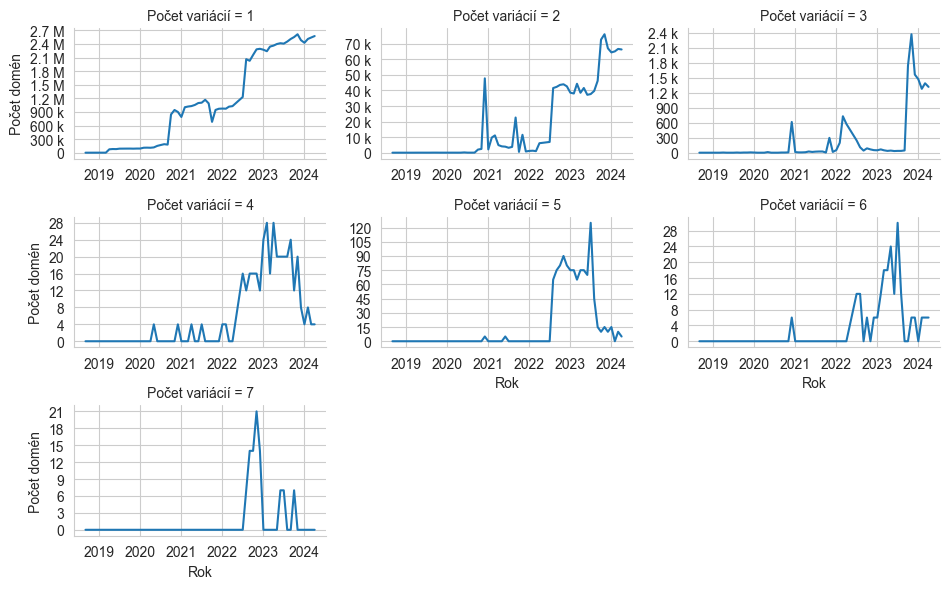

In [41]:
to_plot = variations_data.copy()

to_plot = to_plot.stack().reset_index()
to_plot['Dátum'] = to_plot['Dátum'].map(pd.to_datetime)
to_plot['Počet variácií'] = to_plot['Počet variácií'].astype('int64')  

to_plot.rename(columns={0: 'domain_count'}, inplace=True)

months_with_no_data = [pd.to_datetime('2022-05'), pd.to_datetime('2022-06')]
to_plot = to_plot.drop(to_plot[to_plot['Dátum'].isin(months_with_no_data)].index)

sns.set_style('whitegrid')

g = sns.relplot(to_plot, kind='line', x='Dátum', y='domain_count', 
                col='Počet variácií', col_wrap=3, 
                height=2, aspect=1.6, 
                facet_kws={'sharey': False, 'sharex': False}
                )

for idx, ax in enumerate(g.axes):
    ax.xaxis.remove_overlapping_locs = False
    years = mdates.YearLocator()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    ax.xaxis.set_minor_locator(ticker.NullLocator())
    

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    ax.tick_params(axis='x', which="minor", rotation=90, labelsize=9)

g.set_xlabels("Rok")
g.set_ylabels("Počet domén")

g.tight_layout()

g.savefig("graphs/httparchive_nel_config_variability_dist.pdf")
